# A gentle introduction to time-series analysis and forecasting

In [1]:
import sys
!{sys.executable} -m pip install yfinance
!{sys.executable} -m pip install statsmodels


[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa as tsa
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from datetime import datetime

All time-series data can be decomposed into the following:
- Trend
- Seasonality
- Random Error

When considering to build a time-series model, one must consider the following:

- Is there a trend, meaning that, on average, the measurements tend to increase (or decrease) over time?
- Is there seasonality, meaning that there is a regularly repeating pattern of highs and lows related to calendar time such as seasons, quarters, months, days of the week, and so on?
- Are there outliers? In regression, outliers are far away from your line. With time series data, your outliers are far away from your other data.
- Is there a long-run cycle or period unrelated to seasonality factors?
- Is there constant variance over time, or is the variance non-constant?
- Are there any abrupt changes to either the level of the series or the variance? 

## Traditional Forecasting Using Trend and Seasonality

    Traditionally, time series forecasting was done using regression methods. For example, we can use time as our independent variable and fit a regression line with the data.

$$
 y_t = \beta_0 + \beta_1 * t + u_i
$$

Here, t is the time period and y_t is our dependent variable. The t variable is used in this model as a proxy for "trend" of our time series data.

### Example

In [3]:
df_sales = pd.read_csv("Sales_RegressionOnTime.csv")


In [4]:
df_sales.columns = ["Sales"]
df_sales["Time_Period"] = df_sales.index + 1
df_sales

,Sales,Time_Period
0,680,1
1,600,2
2,745,3
3,925,4
4,920,5
5,680,6
6,1000,7
7,1125,8
8,1150,9
9,920,10


#### Linear Trend

In [5]:
sales_ts_model = smf.ols("Sales ~ Time_Period", data=df_sales).fit()
print(sales_ts_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     103.1
Date:                Wed, 02 Nov 2022   Prob (F-statistic):           7.05e-09
Time:                        15:45:19   Log-Likelihood:                -136.51
No. Observations:                  20   AIC:                             277.0
Df Residuals:                      18   BIC:                             279.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     375.0000    109.126      3.436      

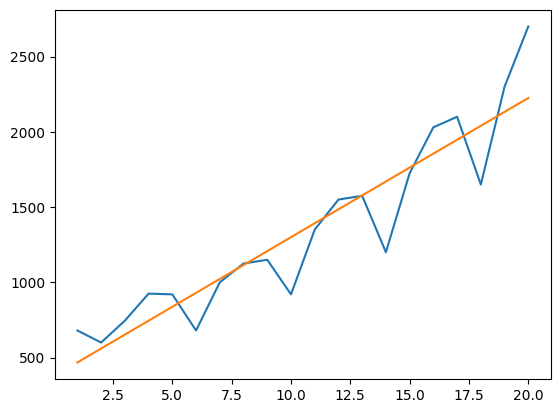

In [6]:
plt.plot(df_sales["Time_Period"], df_sales["Sales"])
plt.plot(df_sales["Time_Period"], sales_ts_model.fittedvalues)

#### Quadratic Trend

In [7]:
df_sales["Sq_Time_Period"] = df_sales["Time_Period"] ** 2
sales_ts_model = smf.ols("Sales ~ Time_Period + Sq_Time_Period", data=df_sales).fit()
print(sales_ts_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     71.26
Date:                Wed, 02 Nov 2022   Prob (F-statistic):           5.43e-09
Time:                        15:45:20   Log-Likelihood:                -133.18
No. Observations:                  20   AIC:                             272.4
Df Residuals:                      17   BIC:                             275.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        683.0921    152.286      4.

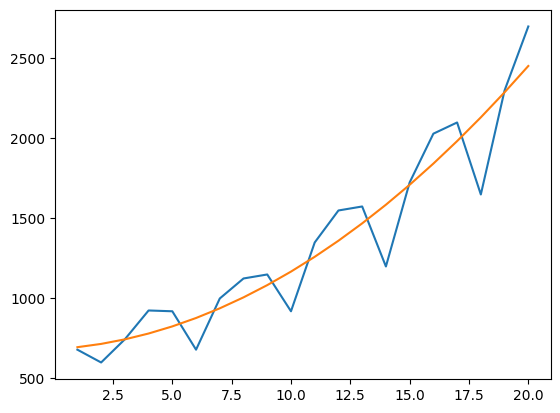

In [8]:
plt.plot(df_sales["Time_Period"], df_sales["Sales"])
plt.plot(df_sales["Time_Period"], sales_ts_model.fittedvalues)

#### Incorporating Seasonality

We can dummify the data based on quarters and use these dummy variables to incorporate seasonality into our model.

In [48]:
df_sales["Quarter"] = [1, 2, 3, 4] * 5

In [45]:
df_sales["Quarter"]

0     1
1     2
2     3
3     4
4     1
5     2
6     3
7     4
8     1
9     2
10    3
11    4
12    1
13    2
14    3
15    4
16    1
17    2
18    3
19    4
Name: Quarter, dtype: int64

In [10]:
# Creating dummy variables
dummies_quarter = pd.get_dummies(df_sales["Quarter"])
dummies_quarter.drop(4, axis=1, inplace=True)
dummies_quarter.columns = ["Q1", "Q2", "Q3"]
dummies_quarter = dummies_quarter.astype(bool)

In [46]:
dummies_quarter

,Q1,Q2,Q3
0,True,False,False
1,False,True,False
2,False,False,True
3,False,False,False
4,True,False,False
5,False,True,False
6,False,False,True
7,False,False,False
8,True,False,False
9,False,True,False


In [11]:
df_sales = df_sales.join(dummies_quarter)

In [12]:
sales_ts_model = smf.ols("Sales ~ Time_Period + Sq_Time_Period + Q1 + Q2 + Q3", data=df_sales).fit()
print(sales_ts_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     168.7
Date:                Wed, 02 Nov 2022   Prob (F-statistic):           5.38e-12
Time:                        15:45:20   Log-Likelihood:                -114.42
No. Observations:                  20   AIC:                             240.8
Df Residuals:                      14   BIC:                             246.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        878.8595     76.667     11.

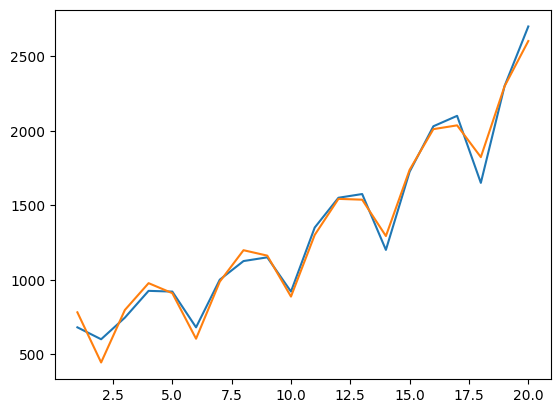

In [13]:
plt.plot(df_sales["Time_Period"], df_sales["Sales"])
plt.plot(df_sales["Time_Period"], sales_ts_model.fittedvalues)

## Metrics

In time series analysis, the most popular metrics for measuring the fit of your model are the following:

$$ 
MAE: \Sigma{\frac{|y_i - \hat{y_i}|}{n}}
$$
$$
MSE: \Sigma{\frac{(y_i - \hat{y_i})^2}{n}}
$$
$$
RMSE: \sqrt{\Sigma{\frac{(y_i - \hat{y_i})^2}{n}}}
$$
$$
MAPE: \frac{1}{n} * {\Sigma{\frac{|y_i - \hat{y_i}|}{n}}} * 100
$$

## Another approach to Seasonality

Lets revisit the previous approach in another example

In [14]:
df_flights = pd.read_csv("us-air-carrier-traffic-statistic.csv")
df_flights["Time_Period"] = df_flights.index + 1

In [15]:
df_flights.head()

,miles,Time_Period
0,41972194,1
1,42054796,2
2,50443045,3
3,47112397,4
4,49118248,5


In [16]:
df_flights["Labels"] = pd.date_range(start="1996-01-01", end="2012-12-31", freq="M")

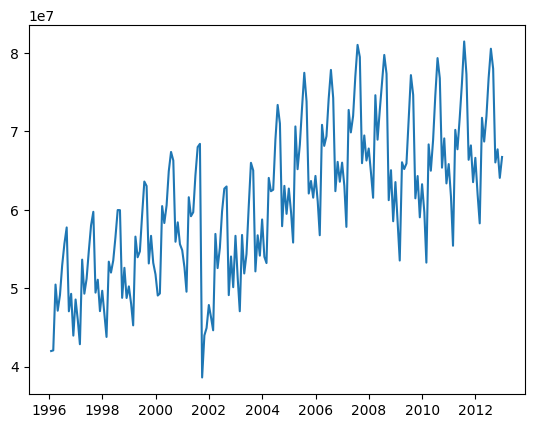

In [17]:
plt.plot(df_flights["Labels"], df_flights["miles"])

As you can see, the seasonality seems to be occuring on a monthly basis. Let's try to add a seasonality variable.

In [18]:
# Adding monthly seasonality
reps = df_flights.shape[0] / 12
df_flights["Seasons"] = [i for i in range(1,13)] * int(reps)


In [19]:
dummy_monthly = pd.get_dummies(df_flights["Seasons"])
dummy_monthly.drop(12, axis=1, inplace=True)
dummy_monthly.columns = [f"Q{i}" for  i in range(1, 12)]
dummy_monthly = dummy_monthly.astype(bool)
df_flights = df_flights.join(dummy_monthly)

In [20]:
df_flights.columns

Index(['miles', 'Time_Period', 'Labels', 'Seasons', 'Q1', 'Q2', 'Q3', 'Q4',
       'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11'],
      dtype='object')

In [21]:
ols_ts_model = smf.ols("miles ~ Time_Period + Q1 + Q2 + Q3 + Q4 + Q5 + Q6 + Q7 + Q8 + Q9 + Q10 + Q11", data=df_flights).fit()
print(ols_ts_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  miles   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     105.1
Date:                Wed, 02 Nov 2022   Prob (F-statistic):           2.85e-77
Time:                        15:45:21   Log-Likelihood:                -3360.3
No. Observations:                 204   AIC:                             6747.
Df Residuals:                     191   BIC:                             6790.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    4.687e+07   9.78e+05     47.934      

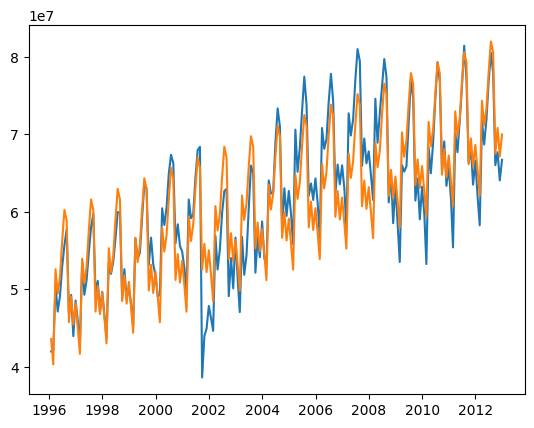

In [22]:
plt.plot(df_flights["Labels"], df_flights["miles"])
plt.plot(df_flights["Labels"], ols_ts_model.fittedvalues)


### Additive and Multiplicative Models

Time series models can be additive or multiplicative. The formulas are as follows:

$$
y_t = T(x) + S(x) + R(x)
$$

$$
y_t = T(x) * S(x) * R(x)
$$


We can remove the trend's effect from the dependent variable. To do this, we can fit a trend model and then fetch the residuals between it and the dependent variable depeding on the type of model.

$$
y_t - T(x) = S(x) + R(x)
$$
$$
\frac{y_t}{T(x)} = S(x) * R(x)
$$

### Additive Model

In [23]:
ols_trend_model = smf.ols("miles ~ Time_Period", data=df_flights).fit()
# Subtracting trend to get seasonal values
df_flights["add_mae"] = df_flights["miles"] - ols_trend_model.fittedvalues
# Groupby and aggregate trend based on avg
seasonality = df_flights.groupby("Seasons").agg({"add_mae": np.mean})["add_mae"].values.tolist() * 17

In [43]:
# Predicted values
pred_miles_add = ols_trend_model.fittedvalues + seasonality 

In [25]:
mae = mean_absolute_error(df_flights["miles"], pred_miles_add)
mape = mean_absolute_percentage_error(df_flights["miles"], pred_miles_add)
mse = mean_squared_error(df_flights["miles"], pred_miles_add)

print(f"MSE : {mse}")
print(f"MAPE: {mape}")
print(f"MAE: {mae}")

MSE : 11880644640249.475
MAPE: 0.047396219834919935
MAE: 2814247.013902041


### Multiplicative Model

In [26]:
ols_trend_model = smf.ols("miles ~ Time_Period", data=df_flights).fit()
# Dividing trend to get seasonal values
df_flights["mult_mae"] = df_flights["miles"] / ols_trend_model.fittedvalues
# Groupby and aggregate trend based on avg
seasonality = df_flights.groupby("Seasons").agg({"mult_mae": np.mean})["mult_mae"].values.tolist() * 17

In [27]:
pred_miles_multiply = ols_trend_model.fittedvalues * seasonality 

In [28]:
mae = mean_absolute_error(df_flights["miles"], pred_miles_multiply)
mape = mean_absolute_percentage_error(df_flights["miles"], pred_miles_multiply)
mse = mean_squared_error(df_flights["miles"], pred_miles_multiply)

print(f"MSE : {mse}")
print(f"MAPE: {mape}")
print(f"MAE: {mae}")

MSE : 11521241367137.057
MAPE: 0.04573721957715068
MAE: 2737008.1611240273


You should only use regression if you feel that the trend is more pronounced.
Use additive trend when the seasonality is constant. Use multiplicative when seasonality is increasing.

## Smoothing Techniques

Often a good approach for building time series models is using smoothing methods. In this secton, we will take a look at some simple smoothing methods before looking at exponential smoothing

### Simple Moving Averages

In [29]:
sales = np.random.randint(15, 20, size=30)
df_ma = pd.DataFrame()
df_ma["sales"] = sales

In [30]:
df_ma["SMA_1"] = df_ma["sales"].rolling(1).mean()

In [53]:
df_ma["SMA_2"] = df_ma["sales"].rolling(2).mean()
df_ma[["sales", "SMA_2"]]

,sales,SMA_2
0,19,NaN
1,19,19.0
2,19,19.0
3,18,18.5
4,17,17.5
5,16,16.5
6,18,17.0
7,18,18.0
8,17,17.5
9,16,16.5


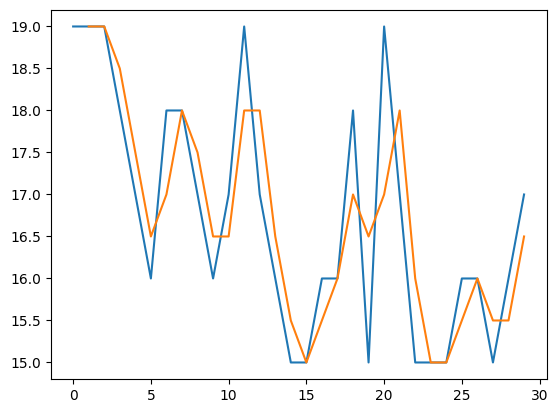

In [32]:
plt.plot(df_ma.index, df_ma["sales"])
plt.plot(df_ma.index, df_ma["SMA_2"])

### Weighted Moving Averages

In [33]:
weights = [3/6, 2/6, 1/6]
sum_weights = np.sum(weights)
df_ma["WMA_3"] = df_ma["sales"].rolling(3).apply(lambda x: np.sum(weights*x) / sum_weights, raw=False)
df_ma

,sales,SMA_1,SMA_2,WMA_3
0,19,19.0,NaN,NaN
1,19,19.0,19.0,NaN
2,19,19.0,19.0,19.000000
3,18,18.0,18.5,18.833333
4,17,17.0,17.5,18.333333
5,16,16.0,16.5,17.333333
6,18,18.0,17.0,16.833333
7,18,18.0,18.0,17.000000
8,17,17.0,17.5,17.833333
9,16,16.0,16.5,17.333333


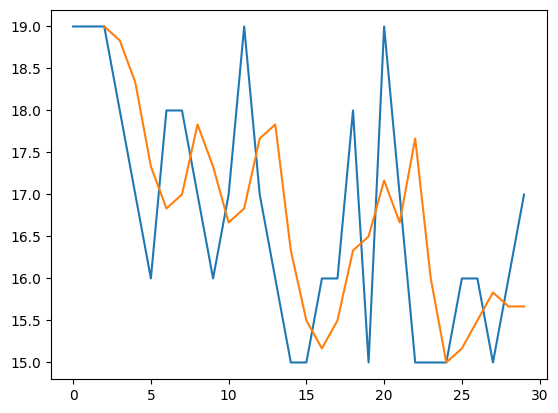

In [34]:
plt.plot(df_ma.index, df_ma["sales"])
plt.plot(df_ma.index, df_ma["WMA_3"])

Although moving averages are a good way to dampen time series models to remove noise, misapplication of them can be detrimental to our goals. For example, if we smoothen a time series over longer periods of moving averages, we risk removing trend and seasonality from it.

Alternatively, moving averages over shorter durations may help maintain trend and seasonality but determining the optimal period is tricky. Too few periods will fail to remove fluctuations and too long periods dampen the data too much.

Hence once alternative is to use all older periods by giving a greater weight to recent periods. This is called exponential smoothing.


### Exponential Smoothing

$$\hat{Y_{t + 1}} = \hat{Y_t} + \alpha * (Y_t - \hat{Y_t})$$

The above equation indicates that the predicted value of time period t + 1 is the same as the predicted value for the previous period t plus and adjustment for the error made in predicting the previous period's value at $$\alpha * (Y_t - \hat{Y_t})$$

(Equation 1)
$$\hat{Y_{t + 1}} = \hat{Y_t} + \alpha * (Y_t - \hat{Y_t})$$

Can be rewritten as (Equation 2):
$$\hat{Y_{t + 1}} = \alpha * Y_t + (1 - \alpha) * \hat{Y_t}$$ 

Can also be rewritten as (Equation 3):
$$\hat{Y_{t + 1}} = Y_t - (1 - \alpha) * (Y_t - \hat{Y_t})$$

From equation 2 we can derive:
$$\hat{Y_{t + 1}} = \alpha * Y_t + \alpha * (1 - \alpha) * Y_{t - 1} + \alpha * (1 - \alpha)^2 * Y_{t - 2} + ... + \alpha * (1 - a)^n * Y_{t - n} + ...$$

The equation above is the exponential smoothing function.

### Ways to interpret exponential smoothing

(Equation 1)
$$\hat{Y_{t + 1}} = \hat{Y_t} + \alpha * (Y_t - \hat{Y_t})$$

Previous forecast plus fraction of previous error


(Equation 2):
$$\hat{Y_{t + 1}} = \alpha * Y_t + (1 - \alpha) * \hat{Y_t}$$ 

Interpolation between previous forecast and previous observation

(Equation 3):
$$\hat{Y_{t + 1}} = Y_t - (1 - \alpha) * (Y_t - \hat{Y_t})$$

Previous observation minus fraction 1 - of previous error.

(Equation 4):
$$\hat{Y_{t + 1}} = \alpha * Y_t + \alpha * (1 - \alpha) * Y_{t - 1} + \alpha * (1 - \alpha)^2 * Y_{t - 2} + ... + \alpha * (1 - a)^n * Y_{t - n} + ...$$

Exponentially weighted average

In [35]:
df_ma["EMA"] = df_ma["sales"].ewm(alpha=0.5).mean()

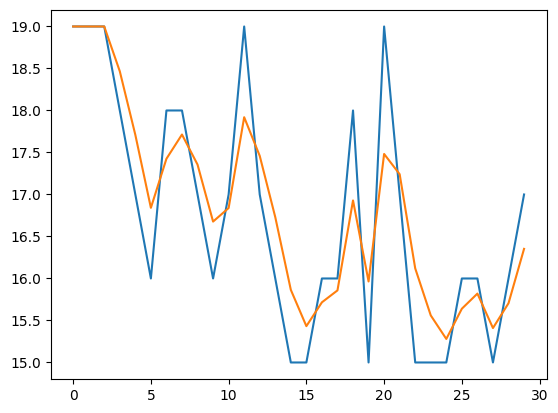

In [36]:
plt.plot(df_ma.index, df_ma["sales"])
plt.plot(df_ma.index, df_ma["EMA"])

In practice, single exponential smoothing like the one above may not be sufficient if there is the presence of trend or seasonality in data. For trend, we use a method known as double exponential smoothing. For seasonality, we apply an additional smoothing component (triple exponential smoothing).

## Autocorrelations and Partial Autocorrelations

Unlike descriptive statistics for cross-sectional data, temporal or time series data is dependent on order (time period). 

Hence autocorrelations are important for identifying potential models.

### Autocorrelation

Recall the correlation formula:

$$
Cor(A, B) = \frac{\Sigma_{i=1}^n({A_i - \mu_A})*({B_i - \mu_B})}{\sqrt{\Sigma_{i=1}^n({A_i - \mu_A})^2*\Sigma_{i=1}^n({B_i - \mu_B})^2}}
$$

We can use this formula for computing autocorrelation:

$$
Cor(Y_t, Y_{t-k}) = \frac{\Sigma_{t=k+1}^T({Y_t - \mu_Y})*({Y_{t - k} - \mu_Y})}{\sqrt{\Sigma_{t=1}^T({Y_t - \mu_Y})^2*\Sigma_{t=1}^T({Y_{t - k} - \mu_Y})^2}}
$$

Because of stationary properties, we can reduce the above term to:

$$
Cor(Y_t, Y_{t-k}) = \frac{\Sigma_{t=k+1}^T({Y_t - \mu_Y})*({Y_{t - k} - \mu_Y})}{\Sigma_{t=1}^T({Y_t - \mu_Y})^2}
$$

In [37]:
df_msft = yf.download(tickers = 'MSFT', start="2010-01-01", end="2022-01-01",interval="1mo")

[*********************100%***********************]  1 of 1 completed


In [38]:
def fetch_acf(df, lag_list):
    X = df["Adj Close"] - df["Adj Close"].mean()
    acf_list = []
    for item in lag_list:
        cov = sum(X[item:].values * X[:len(X) - item].values)
        denom = sum(X.values * X.values)
        acf_list.append(cov/denom)
    return acf_list

In [39]:
acf_list = fetch_acf(df_msft, lag_list=[i for i in range(22)])
acf_list

[1.0,
 0.9570689130551184,
 0.9168178320957373,
 0.873656942514176,
 0.8440175232509656,
 0.8063296634889564,
 0.7725814064013494,
 0.7414262458814623,
 0.7139529556190699,
 0.6847552962033517,
 0.6595441861584741,
 0.6341026527556647,
 0.6078428846791003,
 0.5823862975200075,
 0.5598857355359478,
 0.5376884139976367,
 0.5127981558837968,
 0.48158444312087045,
 0.4555766415947382,
 0.4284089310732125,
 0.40637951176815257,
 0.3855368894367789]

In [40]:
acf_darts = tsa.stattools.acf(df_msft["Adj Close"])
acf_darts

array([1.        , 0.95706891, 0.91681783, 0.87365694, 0.84401752,
       0.80632966, 0.77258141, 0.74142625, 0.71395296, 0.6847553 ,
       0.65954419, 0.63410265, 0.60784288, 0.5823863 , 0.55988574,
       0.53768841, 0.51279816, 0.48158444, 0.45557664, 0.42840893,
       0.40637951, 0.38553689])

### Partial Autocorrelation

Partial autocorrelation refers to the Beta coefficients of the following regression:

$$
y_t = \beta_0 + \Sigma_{i = 1}^k{\beta_i * y_{t - i}}
$$

Where each beta corresponds to the partial autocorrelation between the kth lag and the dependent variable

In [41]:
def fetch_pacf(df, lag=10):
    X = pd.DataFrame(tsa.tsatools.lagmat(df["Adj Close"], lag))
    pacf_list = []
    for l in range(1, lag + 1):
        glm = LinearRegression().fit(X=X.iloc[l:,:l], y=df.reset_index().loc[l:, "Adj Close"])
        pacf_list.append(glm.coef_[-1])
    return pacf_list
pacf_res = fetch_pacf(df_msft)
pacf_res

[1.0332190111619672,
 0.4518027544749158,
 0.15294028219030778,
 0.19533825324030793,
 0.06810824583263136,
 0.2985477171396795,
 0.2902799225471745,
 -0.19914093012252912,
 -0.029417674036615285,
 0.3014403703684808]

In [42]:
tsa.stattools.pacf(df_msft["Adj Close"], nlags=10, method="OLS")

array([ 1.        ,  1.03321901,  0.45180275,  0.15294028,  0.19533825,
        0.06810825,  0.29854772,  0.29027992, -0.19914093, -0.02941767,
        0.30144037])

The main goal behind using ACF and PACF is to be able to make non-stationary time series data stationary. Stationary time series have desirable properties (constant mean, variance over time), which makes it easier to forecast values.

## Readings:

* https://people.duke.edu/~rnau/411avg.htm#BrownLES
* https://otexts.com/fpp2/expsmooth.html
* https://online.stat.psu.edu/stat510/lesson/2
* https://otexts.com/fpp2/arima.html
